Files already downloaded and verified
Files already downloaded and verified
Shape of train: (50000, 32, 32, 3)
Shape of test: (10000, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..1.6417668].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.3396237].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.514088].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.6366696].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.6366696].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..1.1183741].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657

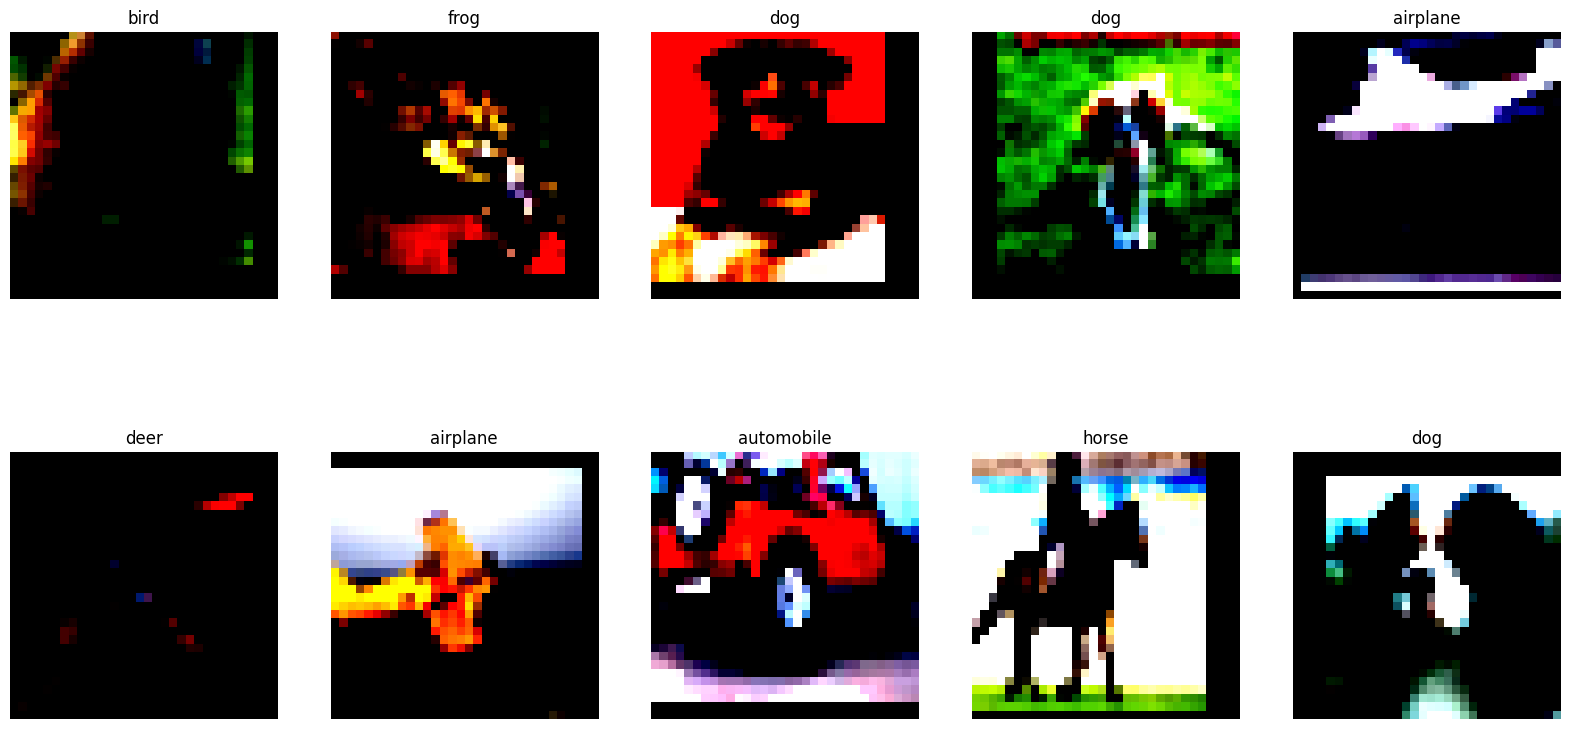

In [55]:
import matplotlib.pyplot as plt
import numpy as np
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

print(f"Shape of train: {trainloader.dataset.data.shape}")
print(f"Shape of test: {testloader.dataset.data.shape}")

dataiter = iter(trainloader)
images, labels = next(dataiter)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(np.transpose(images[i], (1, 2, 0)))
    plt.title(classes[labels[i]])
    plt.axis('off')
plt.show()

In [56]:
import torch 
import torch.nn as nn
from collections import OrderedDict
import torch.nn.functional as F
class Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(Transition, self).__init__()
        self.norm = nn.BatchNorm2d(num_input_features)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, padding=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

class DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(DenseLayer, self).__init__()
        
        self.norm1 = nn.BatchNorm2d(num_input_features)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)
        
        self.norm2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.drop_rate = float(drop_rate)

    def forward(self, x):
        
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.conv1(x) 
        
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.conv2(x)
        
        if self.drop_rate > 0:
            x = F.dropout(x, p=self.drop_rate, training=self.training)
        return x

class DenseBlock(nn.ModuleDict):

    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = DenseLayer(
                num_input_features = num_input_features + i * growth_rate,
                growth_rate = growth_rate,
                bn_size = bn_size,
                drop_rate = drop_rate,
                memory_efficient = memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, x):
        for name, layer in self.items():
            y = layer(x)
            x = torch.cat([x, y], dim =1)
        return x


class DenseNet(nn.Module):
    def __init__(self, growth_rate, block_config, num_init_features, bn_size, drop_rate, num_classes, 
                 memory_efficient=False):

        super(DenseNet, self).__init__()

        # Convolution and pooling part from table-1
        self.features = nn.Sequential(
            nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=24, bias=False), #Поменяли число входных каналов (по задаче)
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Add multiple denseblocks based on config 
        # for densenet-121 config: [6,12,24,16]
        
        self.denseblocks = nn.Sequential()
        
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.denseblocks.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                # add transition layer between denseblocks to downsample
                trans = Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.denseblocks.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.final_bn = nn.BatchNorm2d(num_features)

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.denseblocks(x)
        x = self.final_bn(x)
        x = F.relu(x, inplace=True)
        x = F.adaptive_avg_pool2d(x, (1,1))
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        return x

In [75]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
    
    return running_loss / len(train_loader), correct, total

In [76]:
def validate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return correct / total

In [77]:
def fit(model, train_loader, test_loader, loss, optimizer, sheduler, num_epochs, device, loss_array):
    best_accuracy = 0
    for epoch in range(num_epochs):
        train_loss, correct_on_epoch, total_on_epoch = train(model, train_loader, loss, optimizer, device)
        loss_array.append(train_loss)
        accuracy = validate(model, test_loader, device)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), "top_model_accuracy")
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {correct_on_epoch / total_on_epoch:.4f}')
        sheduler.step()
    print('Обучение завершено!')

In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
loss = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
densenet = DenseNet(growth_rate=32, block_config=(6,12,24,16),
                  num_init_features=64, bn_size=4, drop_rate=0, num_classes=10).to(device)
optimizer = optim.SGD(densenet.parameters(), 0.1,
                                momentum=0.9,
                                 weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=210)
loss_epochs = []
fit(densenet, trainloader, testloader, loss, optimizer, scheduler,  205, device, loss_epochs)

Epoch [1/205], Train Loss: 1.7428, Train Accuracy: 0.3520
Epoch [2/205], Train Loss: 1.3617, Train Accuracy: 0.5034
Epoch [3/205], Train Loss: 1.1814, Train Accuracy: 0.5734
Epoch [4/205], Train Loss: 1.0590, Train Accuracy: 0.6211
Epoch [5/205], Train Loss: 0.9727, Train Accuracy: 0.6558
Epoch [6/205], Train Loss: 0.9082, Train Accuracy: 0.6805
Epoch [7/205], Train Loss: 0.8678, Train Accuracy: 0.6964
Epoch [8/205], Train Loss: 0.8263, Train Accuracy: 0.7103
Epoch [9/205], Train Loss: 0.8037, Train Accuracy: 0.7189
Epoch [10/205], Train Loss: 0.7880, Train Accuracy: 0.7261
Epoch [11/205], Train Loss: 0.7896, Train Accuracy: 0.7254
Epoch [12/205], Train Loss: 0.7569, Train Accuracy: 0.7373
Epoch [13/205], Train Loss: 0.7521, Train Accuracy: 0.7411
Epoch [14/205], Train Loss: 0.7368, Train Accuracy: 0.7465
Epoch [15/205], Train Loss: 0.7308, Train Accuracy: 0.7474
Epoch [16/205], Train Loss: 0.7185, Train Accuracy: 0.7516
Epoch [17/205], Train Loss: 0.7157, Train Accuracy: 0.7510
Epoch 

In [81]:
net = DenseNet(growth_rate=32, block_config=(6,12,24,16),
                  num_init_features=64, bn_size=4, drop_rate=0, num_classes=10)
net.load_state_dict(torch.load('top_model_accuracy', weights_only=False))
net.to(device)
net.eval()   

DenseNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(24, 24), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (denseblocks): Sequential(
    (denseblock1): DenseBlock(
      (denselayer1): DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [82]:
net.eval()
correct = 0
total = 0
loss_test = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        loss_on_batch = loss(outputs, labels)
        loss_test += loss_on_batch.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Loss on Test: {loss_test/ len(testloader)}, Accuracy on test:{correct / total}')

Loss on Test: 0.43219940453767774, Accuracy on test:0.9


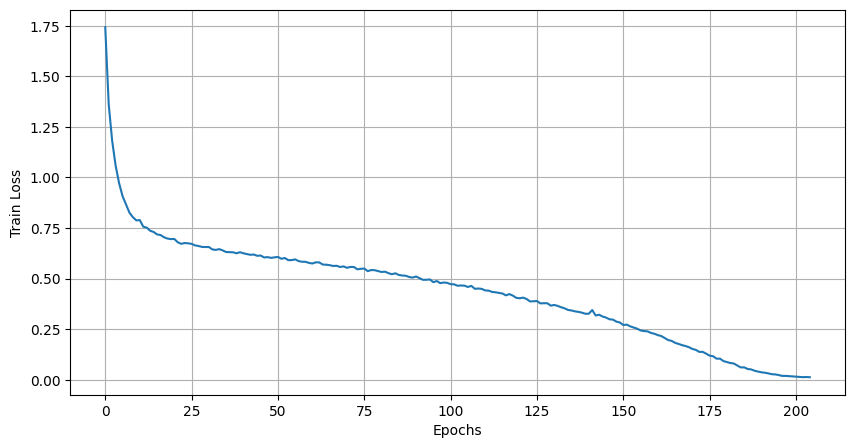

In [83]:
fig, ax = plt.subplots( figsize=(10, 5))
ax.plot(loss_epochs)
ax.set_xlabel('Epochs')
ax.set_ylabel('Train Loss')
ax.grid(True)
plt.show()